In [ ]:
#Logistic model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


# 1. Charger les données
df = pd.read_csv("loan.csv", low_memory=False)

# 2. Garder uniquement les prêts "Fully Paid" et "Charged Off"
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# 3. Sélection des variables
features = ['loan_amnt', 'term', 'int_rate', 'emp_length',
            'annual_inc', 'purpose', 'dti', 'total_acc']
df = df[features + ['target']].copy()

# 4. Nettoyage
df['int_rate'] = df['int_rate'].astype(str).str.rstrip('%').astype(float)
df[['term', 'emp_length', 'purpose']] = df[['term', 'emp_length', 'purpose']].fillna('Unknown')

# 5. Encodage des variables catégorielles
le_dict = {}
for col in ['term', 'emp_length', 'purpose']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# 6. Supprimer les lignes avec NaN restantes
df = df.dropna()

# 7. Séparer X et y
X = df.drop('target', axis=1)
y = df['target']

# 8. Standardiser
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 10. Train/Test Split sur les données rééquilibrées
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 10. Entraînement
model = LogisticRegression(max_iter=3000, class_weight='balanced')
model.fit(X_train, y_train)

# 11. Évaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 12. Sauvegarde
joblib.dump(model, "credit_model_logreg_v3.pkl")
joblib.dump(le_dict, "label_encoders_v3.pkl")
joblib.dump(scaler, "scaler_v3.pkl")



              precision    recall  f1-score   support

           0       0.65      0.65      0.65     41787
           1       0.65      0.64      0.64     41303

    accuracy                           0.65     83090
   macro avg       0.65      0.65      0.65     83090
weighted avg       0.65      0.65      0.65     83090



['scaler_v3.pkl']

C:\Users\djama\AppData\Local\Temp\ipykernel_22124\3430699730.py:16: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


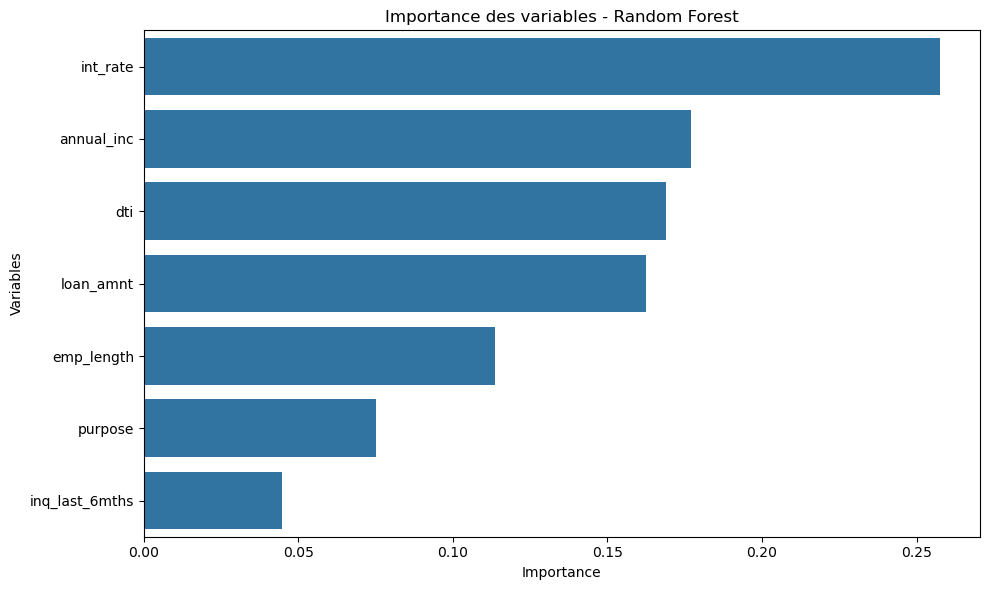


📊 Rapport de classification :
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     41544
           1       0.86      0.85      0.86     41546

    accuracy                           0.86     83090
   macro avg       0.86      0.86      0.86     83090
weighted avg       0.86      0.86      0.86     83090

✅ Modèle et scaler sauvegardés avec succès.


In [16]:
#Création Model RandomForest avec Smote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# 1. Charger les données
df = pd.read_csv("loan.csv")

# 2. Mapping loan_status → target
status_map = {
    "Fully Paid": 0,
    "Does not meet the credit policy. Status: Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1,
    "Does not meet the credit policy. Status: Charged Off": 1,
    "Current": np.nan,
    "Late (31-120 days)": np.nan,
    "Late (16-30 days)": np.nan,
    "Issued": np.nan,
    "In Grace Period": np.nan
}
df['target'] = df['loan_status'].map(status_map)
df = df.dropna(subset=['target'])
df['target'] = df['target'].astype(int)

# 3. Sélection des variables (dti et inq_last_6mths inclus)
features = ['loan_amnt', 'dti', 'int_rate', 'emp_length', 'annual_inc', 'purpose', 'inq_last_6mths']
df = df[features + ['target']].copy()

# 4. Nettoyage
df['int_rate'] = df['int_rate'].astype(str).str.rstrip('%').astype(float)
df[['emp_length', 'purpose']] = df[['emp_length', 'purpose']].fillna('Unknown')
df['inq_last_6mths'] = df['inq_last_6mths'].fillna(0)

# 5. Encodage des variables catégorielles
le_dict = {}
for col in ['emp_length', 'purpose']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# 6. Suppression des lignes restantes avec NaN
df = df.dropna()

# 7. Séparation des données
X = df.drop('target', axis=1)
y = df['target']

# ✅ Sauvegarde de l’ordre des colonnes
feature_order = X.columns.tolist()

# 8. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# 10. Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 11. Modélisation
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 12. Affichage de l’importance des variables
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx])
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

# 13. Évaluation
y_pred = rf.predict(X_test)
print("\n📊 Rapport de classification :")
print(classification_report(y_test, y_pred))

# 14. Sauvegarde des objets
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/credit_model_rf_smote.pkl")
joblib.dump(scaler, "models/scaler_rf_smote.pkl")
joblib.dump(le_dict, "models/label_encoders_rf_smote.pkl")
joblib.dump(feature_order, "models/feature_order.pkl")

print("✅ Modèle et scaler sauvegardés avec succès.")


💸 Dette = $1500 → DTI = 57.14% → Score = 48.0%


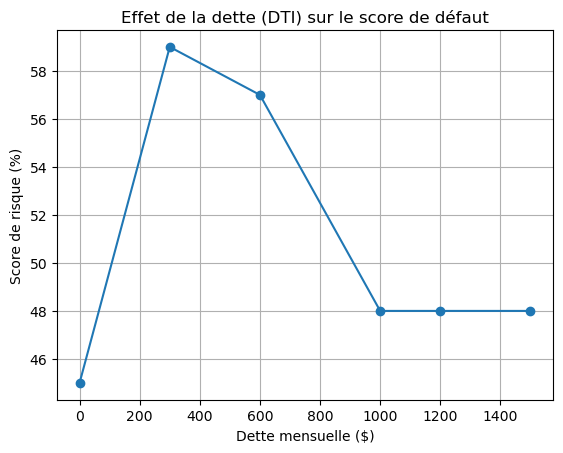

In [15]:
import joblib

# Chargement des objets nécessaires
model = joblib.load("models/credit_model_rf_smote.pkl")
scaler = joblib.load("models/scaler_rf_smote.pkl")
label_encoders = joblib.load("models/label_encoders_rf_smote.pkl")
feature_order = joblib.load("models/feature_order.pkl")
import pandas as pd

# Même profil sauf la dette
debts = [0, 300, 600, 1000, 1500]
results = []

for d in debts:
    dti = min((d * 12) / 30000 * 100, 57.14)

    X = pd.DataFrame([[15000, dti, 18.9, '3 years', 30000, 'credit_card', 2]],
                 columns=['loan_amnt', 'dti', 'int_rate', 'emp_length', 'annual_inc', 'purpose', 'inq_last_6mths'])

X['emp_length'] = label_encoders['emp_length'].transform(X['emp_length'])
X['purpose'] = label_encoders['purpose'].transform(X['purpose'])

X = X[feature_order]
X_scaled = scaler.transform(X)
score = model.predict_proba(X_scaled)[0][1] * 100
results.append((d, dti, round(score, 2)))

for r in results:
    print(f"💸 Dette = ${r[0]} → DTI = {r[1]:.2f}% → Score = {r[2]}%")

import matplotlib.pyplot as plt

# Exemple avec une liste complète
debts = [0, 300, 600, 1000, 1200, 1500]
scores = []

for d in debts:
    dti = min((d * 12) / 30000 * 100, 57.14)
    X = pd.DataFrame([[15000, dti, 18.9, '3 years', 30000, 'credit_card', 2]],
                     columns=['loan_amnt', 'dti', 'int_rate', 'emp_length', 'annual_inc', 'purpose', 'inq_last_6mths'])
    X['emp_length'] = label_encoders['emp_length'].transform(X['emp_length'])
    X['purpose'] = label_encoders['purpose'].transform(X['purpose'])
    X = X[feature_order]
    X_scaled = scaler.transform(X)
    score = model.predict_proba(X_scaled)[0][1] * 100
    scores.append(score)

# Tracer le graphe
plt.plot(debts, scores, marker='o')
plt.title("Effet de la dette (DTI) sur le score de défaut")
plt.xlabel("Dette mensuelle ($)")
plt.ylabel("Score de risque (%)")
plt.grid(True)
plt.show()

C:\Users\djama\AppData\Local\Temp\ipykernel_22124\1254058178.py:11: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


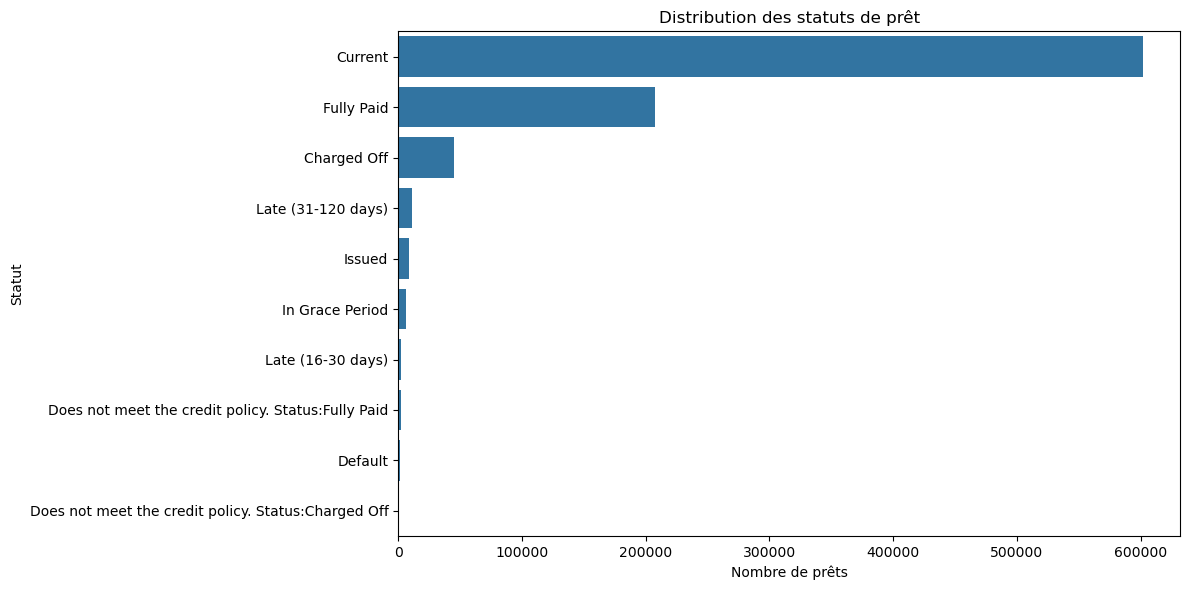

Corrélation DTI / Target :
             dti    target
dti     1.000000  0.114304
target  0.114304  1.000000
📈 Corrélation de chaque variable avec la variable cible (target) :

target                         1.000000
recoveries                     0.449195
collection_recovery_fee        0.309781
int_rate                       0.240890
total_rec_late_fee             0.149428
out_prncp                      0.122960
out_prncp_inv                  0.122958
dti                            0.114304
revol_util                     0.097544
loan_amnt                      0.058292
funded_amnt                    0.058222
funded_amnt_inv                0.056653
inq_last_6mths                 0.056645
total_rec_int                  0.047256
installment                    0.044031
mths_since_last_record         0.042700
delinq_2yrs                    0.017981
open_acc                       0.011357
collections_12_mths_ex_med     0.008024
acc_now_delinq                 0.006358
pub_rec                 

C:\Users\djama\AppData\Local\Temp\ipykernel_22124\1254058178.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")


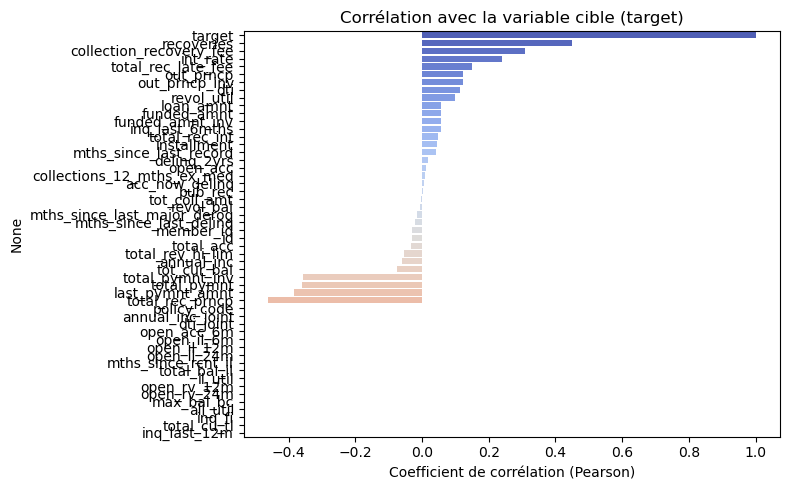

Variables à privilégier : ['recoveries', 'collection_recovery_fee', 'int_rate', 'total_rec_late_fee', 'out_prncp', 'out_prncp_inv', 'dti', 'revol_util', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'total_rev_hi_lim', 'annual_inc', 'tot_cur_bal', 'total_pymnt_inv', 'total_pymnt', 'last_pymnt_amnt', 'total_rec_prncp']
['recoveries', 'collection_recovery_fee', 'int_rate', 'total_rec_late_fee', 'out_prncp', 'out_prncp_inv', 'dti', 'revol_util', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'total_rev_hi_lim', 'annual_inc', 'tot_cur_bal', 'total_pymnt_inv', 'total_pymnt', 'last_pymnt_amnt', 'total_rec_prncp']
📉 Variables avec effet négatif sur le défaut (corrélation négative) :

tot_coll_amt                  -0.001607
revol_bal                     -0.004527
mths_since_last_major_derog   -0.016309
mths_since_last_delinq        -0.019501
member_id                     -0.028493
id                            -0.030247
total_acc                     -0.0325

In [9]:
#Choix des variables loan_status

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Charger les données et visualisation
df = pd.read_csv("loan.csv")
df.head()
df['loan_status']

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='loan_status', order=df['loan_status'].value_counts().index)
plt.title("Distribution des statuts de prêt")
plt.xlabel("Nombre de prêts")
plt.ylabel("Statut")
plt.tight_layout()
plt.show()


status_map = {
    "Fully Paid": 0,
    "Does not meet the credit policy. Status: Fully Paid": 0,
    "Charged Off": 1,
    "Default": 1,
    "Does not meet the credit policy. Status: Charged Off": 1,
    # Autres : statut flou ou prêt en cours → à exclure
    "Current": np.nan,
    "Late (31-120 days)": np.nan,
    "Late (16-30 days)": np.nan,
    "Issued": np.nan,
    "In Grace Period": np.nan
}
df['target'] = df['loan_status'].map(status_map)
df = df.dropna(subset=['target'])
df['target'] = df['target'].astype(int)

df[['dti', 'target']].corr()
print("Corrélation DTI / Target :")
print(df[['dti', 'target']].corr())

# 1. Calcul de la matrice de corrélation
correlation_matrix = df.corr(numeric_only=True)

# 2. Affichage des corrélations avec target
corr_target = correlation_matrix['target'].sort_values(ascending=False)

print("📈 Corrélation de chaque variable avec la variable cible (target) :\n")
print(corr_target)

# 3. Visualisation en barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")
plt.title("Corrélation avec la variable cible (target)")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.tight_layout()
plt.show()

variables_importantes = corr_target[abs(corr_target) > 0.05].drop('target').index.tolist()
print("Variables à privilégier :", variables_importantes)
print(variables_importantes)

# Extraire uniquement les variables corrélées négativement (hors 'target' lui-même)
variables_negatives = corr_target[corr_target < 0].drop('target', errors='ignore')

# Affichage
print("📉 Variables avec effet négatif sur le défaut (corrélation négative) :\n")
print(variables_negatives)

# Optionnel : les 5 plus négatives
print("\n🔻 Top 5 effets les plus négatifs :")
print(variables_negatives.sort_values().head(5))

# Sélection des colonnes numériques
numerical_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Affichage des min et max
for var in numerical_vars:
    min_val = df[var].min()
    max_val = df[var].max()
    print(f"{var} → Min : {min_val:.2f} | Max : {max_val:.2f}")

